### In this notebook we have implemented the signal processing and machine learning techniques to process the seismic data obtained from INSIGHT Mars Rover. We have performed ths following activities in this notebook : 
- Used the Obspy library to read the miniseed (.mseed) files in which the seismic data is encrypted. 
- Used Signal Processing techniques like bandpass filtering and wavelet denoising to remove noise and errors from the seismic data.
- Further plotted the amplitudes of the ground motion velocity vs the time. Calculated the frequency domain represnetation of the signal using Fast Fourier Transform to analyse the frequencies present in the signal. And lastly calculated the phase using the hilbert transform.
- Generated Synthetic dataset from the pre-existing seismic data and performed supervised machine learning algorithm (Logistic Regression) for binary classifictaion of shadow and non-shadow zones seismic data. 

In [16]:

import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from obspy import read
import obspy
from obspy.signal.filter import bandpass
from scipy.signal import hilbert, spectrogram, butter, filtfilt
import pywt
from scipy.interpolate import interp1d
from scipy.fftpack import fft, fftfreq
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
import pandas as pd
import warnings
import seaborn as sns

#### Signal Processing 
- **Bandpass filter**  : Allows only the signals within the speicfied range of frequencies to pass. It helps in removing noise or filtering the desired frqeuencies from teh signal. 
- **Wavelet Denoising** : It decomposes the data into wavelet coefficients, applies a threshold to remove noise, and then reconstructs the denoised signal using inverse wavelet transform.
- **Spike Removal** : It calculates local z-scores to detect spikes and replaces them with interpolated values based on surrounding non-spike data, effectively smoothing out anomalies.

Found 10 mseed files in module_6_data/data


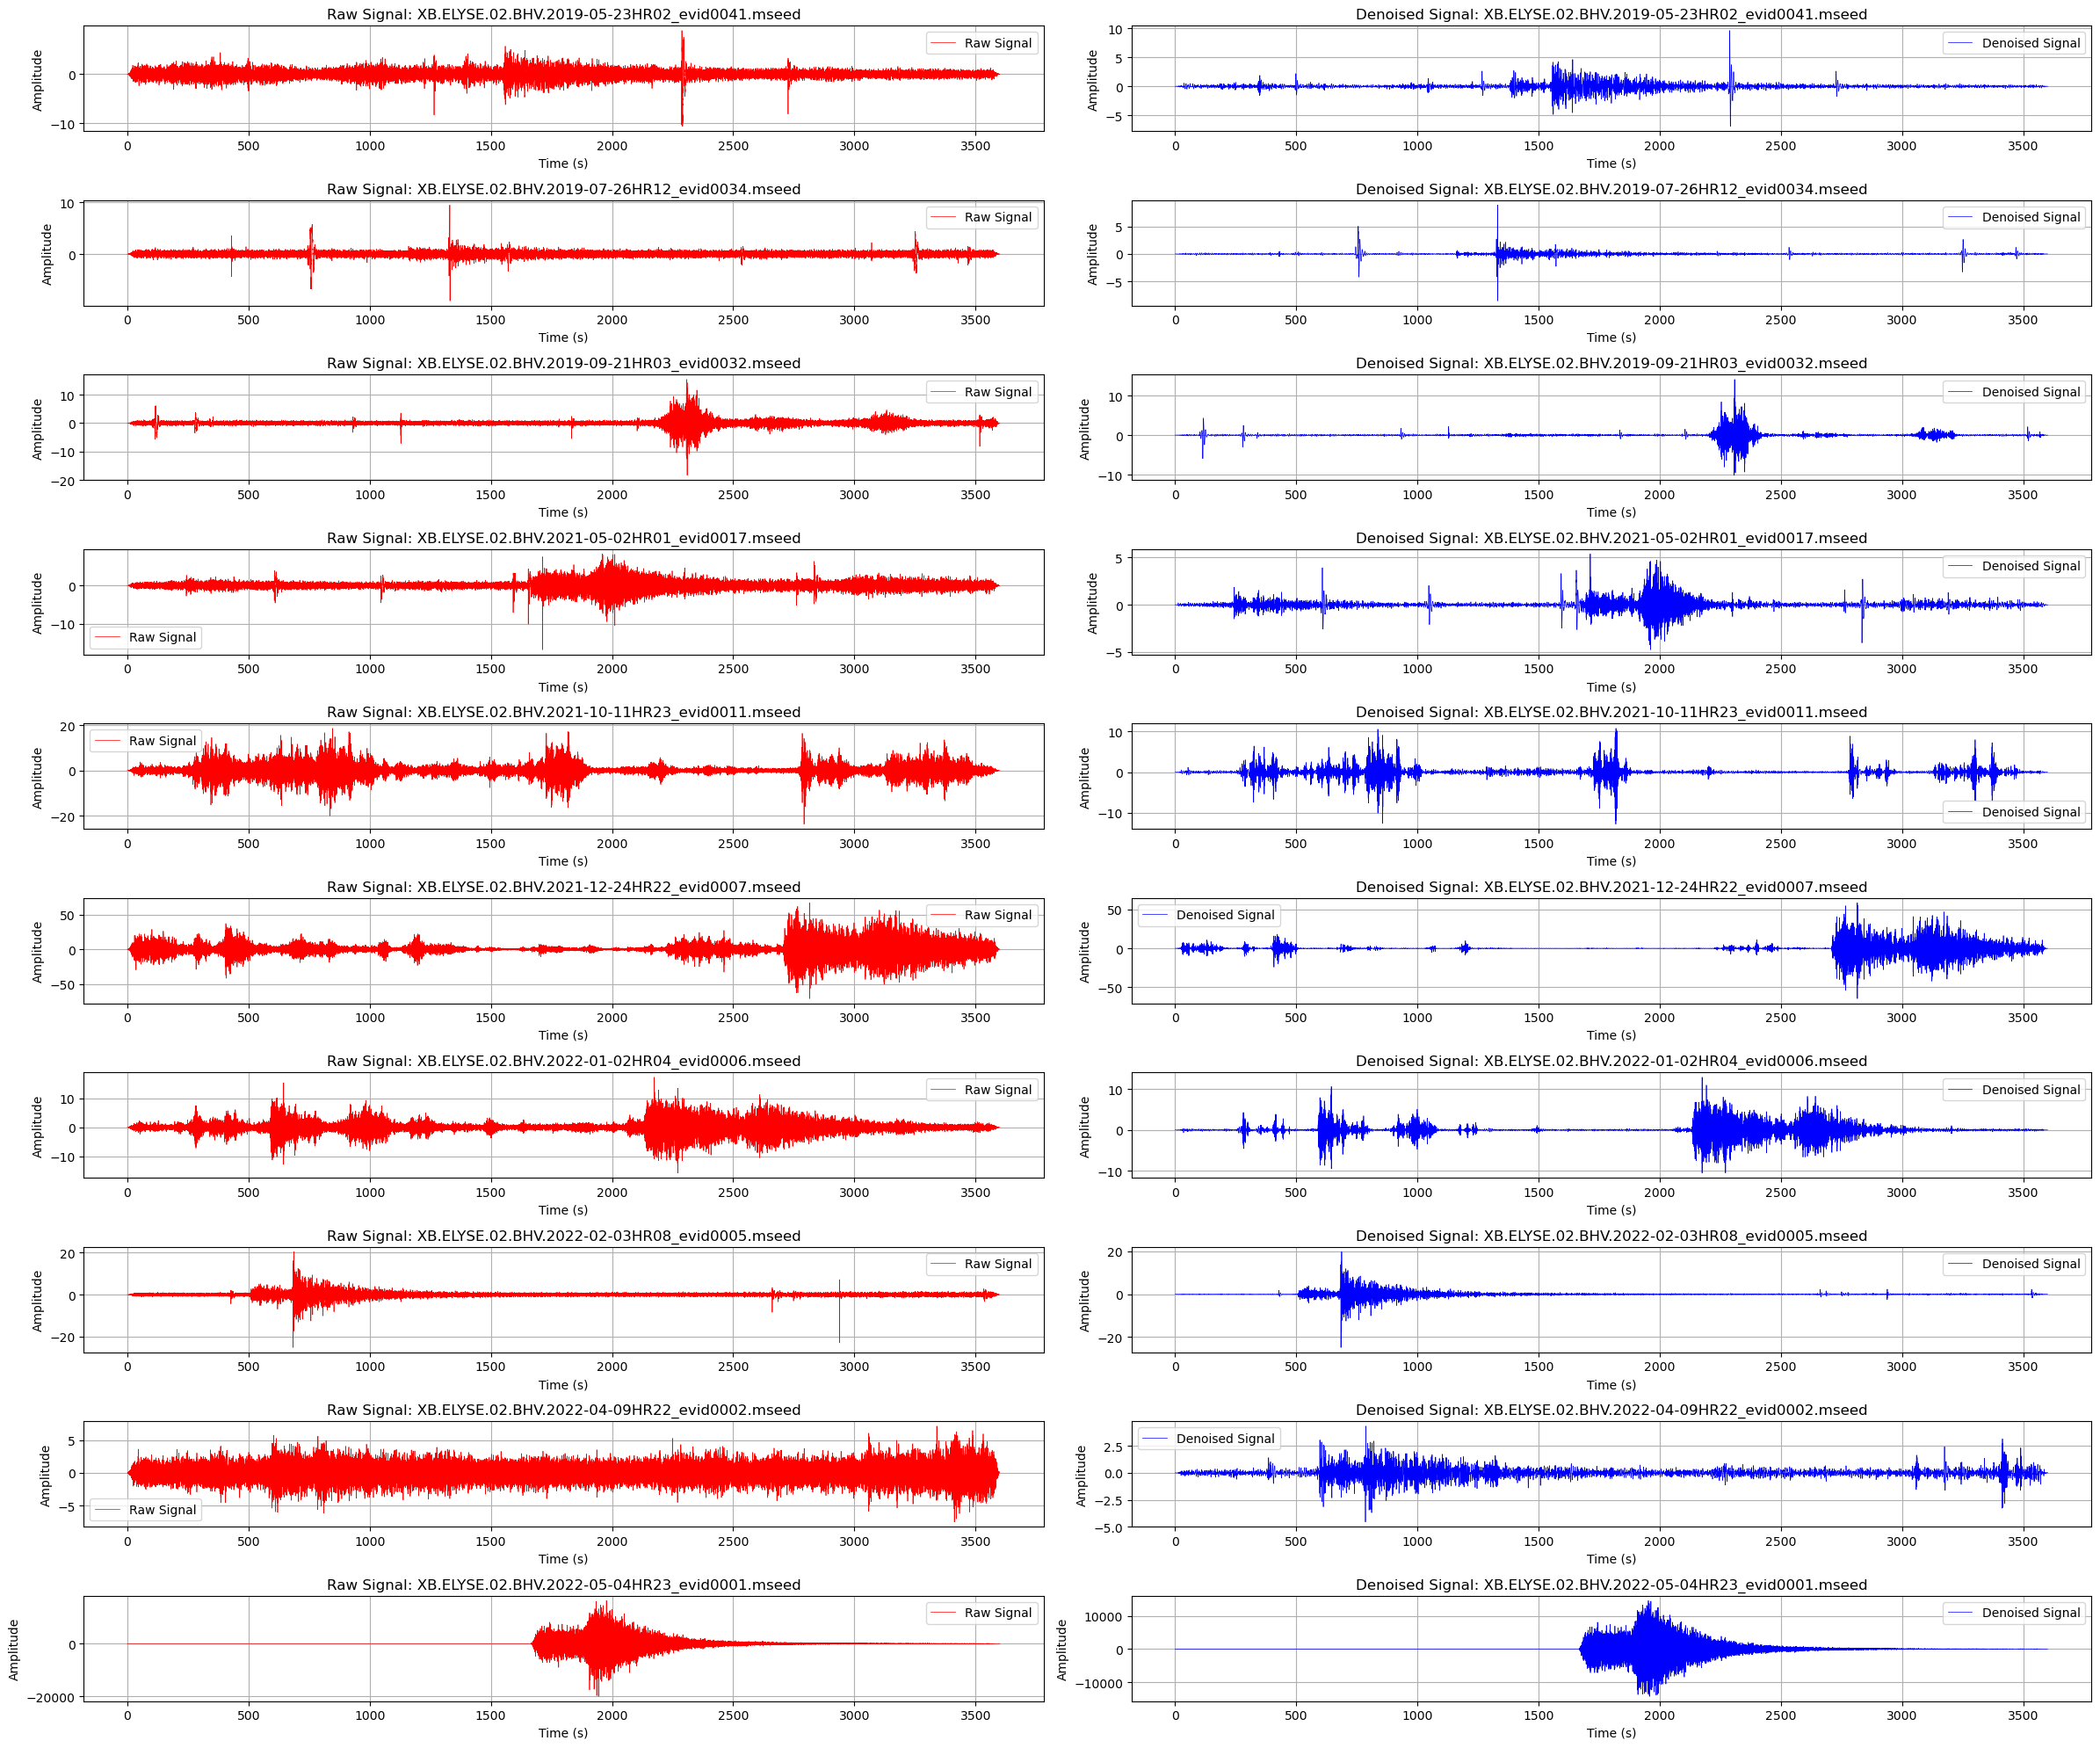

In [17]:
def bandpass_filter(data, sampling_rate, freqmin, freqmax):
    return bandpass(data, freqmin=freqmin, freqmax=freqmax, df=sampling_rate, corners=4, zerophase=True)

def wavelet_denoise(data, wavelet="db6", max_level=4):
    coeffs = pywt.wavedec(data, wavelet, level=max_level)
    threshold = np.sqrt(2 * np.log(len(data))) * np.median(np.abs(coeffs[-1])) / 0.6745
    denoised_coeffs = [coeffs[0]]
    for i in range(1, len(coeffs)):
        denoised_coeffs.append(pywt.threshold(coeffs[i], threshold, mode="soft"))
    return pywt.waverec(denoised_coeffs, wavelet)

def remove_spikes(data, z_threshold=3, window_size=60):
    data = np.asarray(data)
    cleaned_data = data.copy()

    half_window = window_size // 2
    local_mean = np.convolve(data, np.ones(window_size) / window_size, mode='same')
    local_std = np.sqrt(np.convolve((data - local_mean)**2, np.ones(window_size) / window_size, mode='same'))
    
    z_scores = np.abs(data - local_mean) / (local_std + 1e-8) 
    spikes = z_scores > z_threshold
    
    spike_indices = np.where(spikes)[0]
    valid_indices = np.where(~spikes)[0]
    interpolator = interp1d(valid_indices, data[valid_indices], kind="linear", fill_value="extrapolate")
    cleaned_data[spike_indices] = interpolator(spike_indices)
    
    return cleaned_data
warnings.filterwarnings("ignore", category=UserWarning)
directory_path = r"module_6_data/data" 
mseed_files = glob.glob(os.path.join(directory_path, "*.mseed"))
mseed_files.sort() 

print(f"Found {len(mseed_files)} mseed files in {directory_path}")
fig, axes = plt.subplots(nrows=len(mseed_files), ncols=2, figsize=(24, 2*len(mseed_files)))
signals = []
times = []
fs = []

for i, mseed_file in enumerate(mseed_files):
    st = read(mseed_file)
    st.filter('bandpass', freqmin=0.1, freqmax=50.0)
    tr = st[0] 
    sampling_rate = tr.stats.sampling_rate
    
    data = tr.data.astype(np.float32) / (100)
    filtered_data = bandpass_filter(data, sampling_rate, freqmin=0.1, freqmax=25.0)
    spike_removed_data = remove_spikes(filtered_data)
    wavelet_denoised_data = wavelet_denoise(spike_removed_data)
    denoised_data = remove_spikes(wavelet_denoised_data)
    
    t = tr.times()
    ax_raw = axes[i, 0]
    ax_denoised = axes[i, 1]
    
    signals.append(denoised_data)
    times.append(t)
    fs.append(int(sampling_rate))
    
    ax_raw.plot(t, data, color="red", linewidth=0.5, label="Raw Signal")
    ax_raw.set_title(f"Raw Signal: {os.path.basename(mseed_file)}")
    ax_raw.set_xlabel("Time (s)")
    ax_raw.set_ylabel("Amplitude")
    ax_raw.legend()
    ax_raw.grid(True)

    to_plot = denoised_data[:len(t)]
    ax_denoised.plot(t, to_plot, color="blue", linewidth=0.5, label="Denoised Signal")
    ax_denoised.set_title(f"Denoised Signal: {os.path.basename(mseed_file)}")
    ax_denoised.set_xlabel("Time (s)")
    ax_denoised.set_ylabel("Amplitude")
    ax_denoised.legend()
    ax_denoised.grid(True)

plt.tight_layout()
plt.show()

- **Signal Analysis and Visualization** : The code processes multiple seismic signals (or similar time-series data) by performing Fourier Transform and Hilbert Transform to analyze their frequency and phase characteristics.
- **Plots and Visualization** : For each signal, it creates a subplot with four columns, each representing a different aspect of the signal. The time-domain plot shows the raw signal, the amplitude spectrum displays the frequency components, the instantaneous phase plot shows the phase over time, and the spectrogram provides a time-frequency representation of the signal's power.

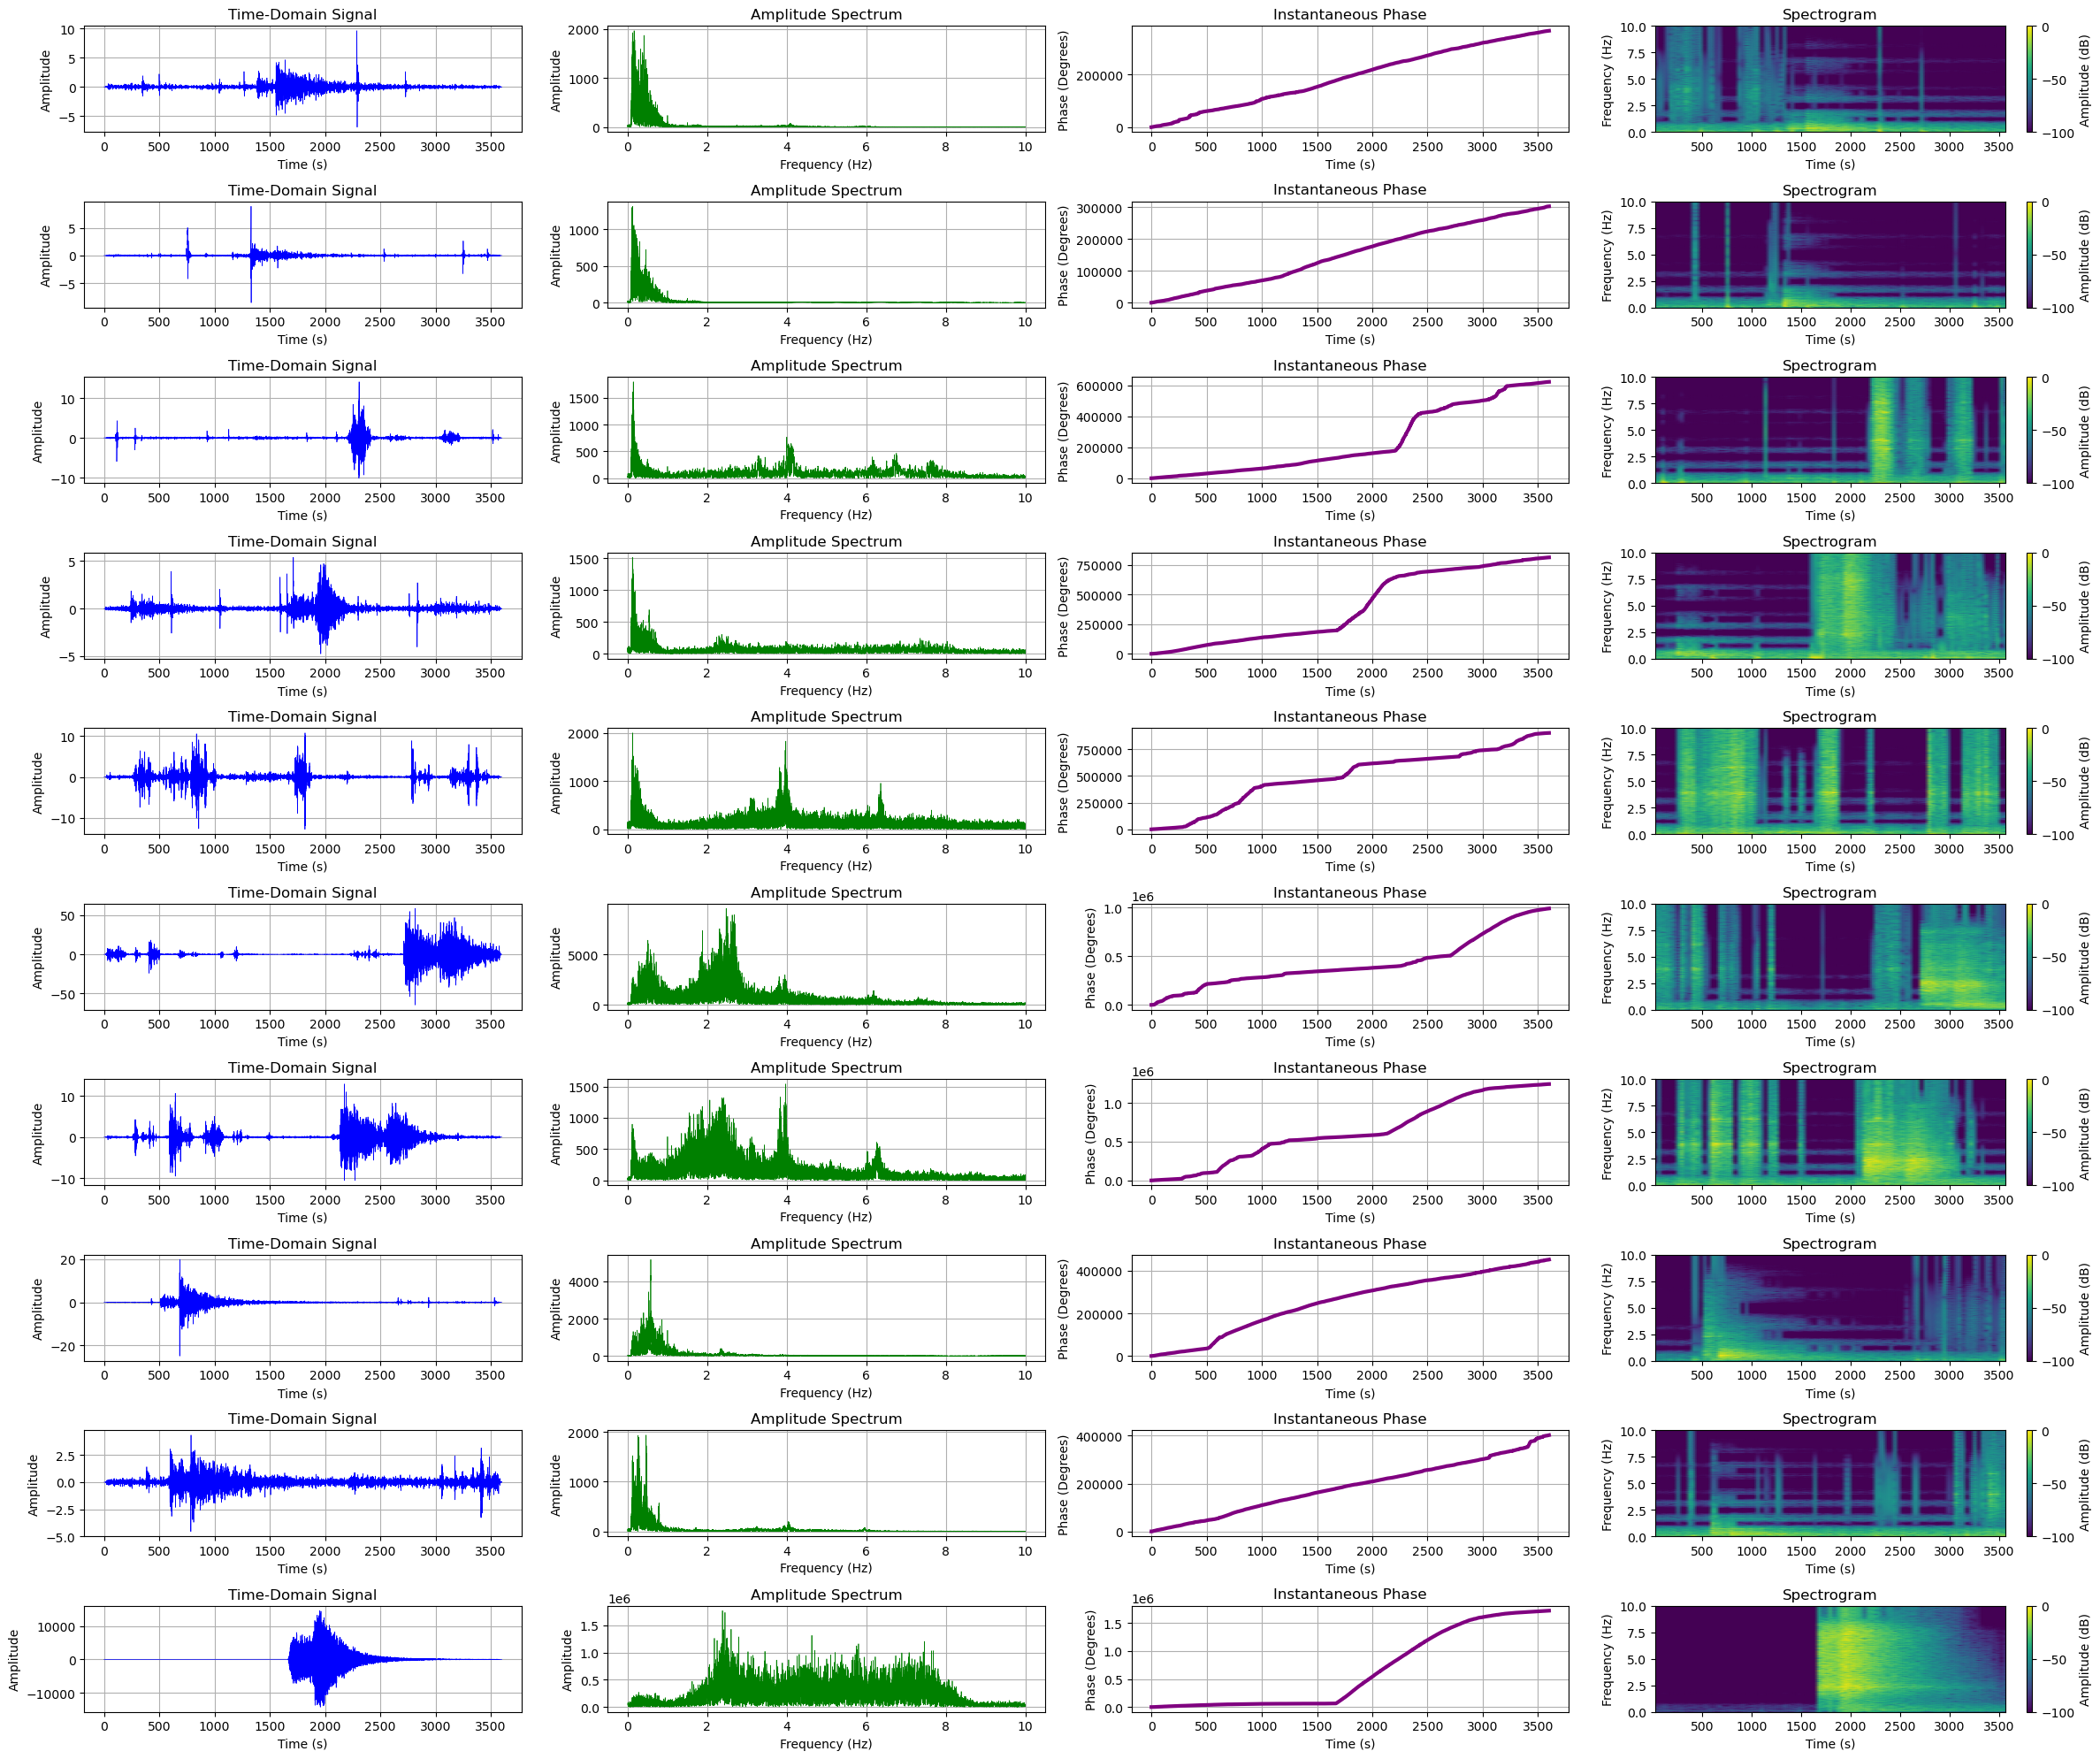

In [18]:
fig, axes = plt.subplots(nrows=len(mseed_files), ncols=4, figsize=(24, 2 * len(mseed_files)))

for i, (time, data, sampling_rate) in enumerate(zip(times, signals, fs)):
    n = len(data)
    frequencies = fftfreq(n, d=1 / sampling_rate)
    fft_values = fft(data)
    amplitude_spectrum = np.abs(fft_values)

    positive_frequencies = frequencies[:n // 2]
    positive_amplitudes = amplitude_spectrum[:n // 2]

    analytic_signal = hilbert(data)
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))

    # (a) Time-Domain Signal
    axes[i, 0].plot(time, data[:len(time)], color='blue', linewidth=0.5)
    axes[i, 0].set_title("Time-Domain Signal")
    axes[i, 0].set_xlabel("Time (s)")
    axes[i, 0].set_ylabel("Amplitude")
    axes[i, 0].grid()

    # (b) Amplitude Spectrum
    axes[i, 1].plot(positive_frequencies, positive_amplitudes, color='green', linewidth=0.5)
    axes[i, 1].set_title("Amplitude Spectrum")
    axes[i, 1].set_xlabel("Frequency (Hz)")
    axes[i, 1].set_ylabel("Amplitude")
    axes[i, 1].grid()

    # (c) Instantaneous Phase
    axes[i, 2].plot(time, np.degrees(instantaneous_phase[:len(time)]), color='purple', linewidth=3)
    axes[i, 2].set_title("Instantaneous Phase")
    axes[i, 2].set_xlabel("Time (s)")
    axes[i, 2].set_ylabel("Phase (Degrees)")
    axes[i, 2].grid()

    # (d) Spectrogram
    f, t_spec, Sxx = spectrogram(data, fs=sampling_rate, nperseg=1024, noverlap=256)
    Sxx_dB = 10 * np.log10(Sxx / np.max(Sxx) + 1e-10)
    im = axes[i, 3].pcolormesh(t_spec, f, Sxx_dB, shading='gouraud', cmap='viridis')
    fig.colorbar(im, ax=axes[i, 3], label="Amplitude (dB)")
    axes[i, 3].set_title("Spectrogram")
    axes[i, 3].set_xlabel("Time (s)")
    axes[i, 3].set_ylabel("Frequency (Hz)")

    # dominant_frequency_index = np.argmax(positive_amplitudes)
    # dominant_frequency = abs(positive_frequencies[dominant_frequency_index])
    # print(f"Dominant Frequency (FFT) for signal {i + 1}: {dominant_frequency:.3f} Hz")

plt.tight_layout()
plt.show()

#### Synthetic Data Generation:
- **Signal Filtering and Noise Addition** : The code applies a bandpass filter to the seismic signal to isolate specific frequency components (P and S waves). It then adds random noise to simulate real-world variability, enhancing the realism of the synthetic data. 
- **Shadow and Non-Shadow Zone Simulation** : The code generates two types of signals: shadow zone and non-shadow zone. The shadow zone signal is created by attenuating and adding noise to a filtered version of the real signal, simulating the effect of seismic waves passing through a shadow zone. The non-shadow zone signal is generated by combining and attenuating P-wave and S-wave components, representing areas not affected by shadowing.

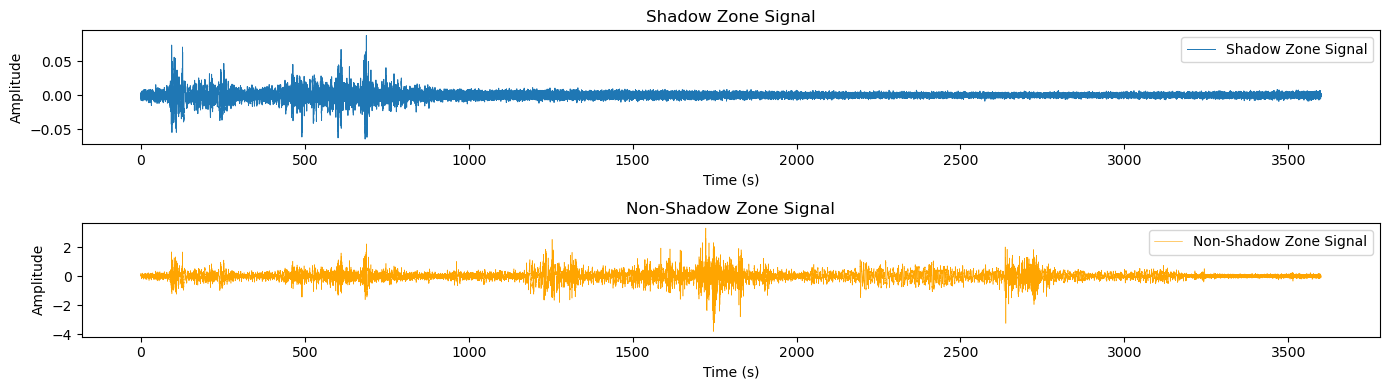

In [26]:
fs = 20  # Sampling frequency (Hz)
real_signal = signals[4]  # Replace with your real seismic signal
n = len(real_signal)
duration = n / fs  # Duration of the signal in seconds
t = times[4]  # Time vector

def bandpass_filter(signal, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

def add_random_noise(signal, noise_level=0.1, variability=0.5):
    time_variation = 1 + variability * np.sin(np.linspace(0, 2 * np.pi, len(signal)))
    noise = np.random.normal(0, noise_level * np.std(signal), len(signal)) * time_variation
    return signal + noise

def apply_attenuation(signal, start_point, fs, decay_factor=0.005):
    time_vector = np.arange(len(signal)) / fs
    attenuation = np.exp(-decay_factor * (time_vector - start_point))
    attenuation[time_vector < start_point] = 1  
    return signal * attenuation

p_wave_start = int(np.random.uniform(0.2, 0.45) * n)
s_wave_start = int(np.random.uniform(0.5, 0.9) * n)

if np.random.rand() < 0.3: 
    shadow_zone_signal = add_random_noise(np.zeros_like(real_signal), noise_level=50, variability=50)
else:
    p_wave_shadow_amplitude = np.random.uniform(0.005, 0.06) 
    p_wave_shadow = p_wave_shadow_amplitude * bandpass_filter(real_signal, lowcut=0.1, highcut=3, fs=fs)
    shadow_zone_signal = np.roll(p_wave_shadow, p_wave_start)
    shadow_zone_signal = apply_attenuation(shadow_zone_signal, p_wave_start / fs, fs, decay_factor=0.2)  # Higher decay factor for more attenuation
    shadow_zone_signal = add_random_noise(shadow_zone_signal, noise_level=0.5, variability=0.3)


p_wave_non_shadow_amplitude = np.random.uniform(0.2, 0.8) 
s_wave_non_shadow_amplitude = np.random.uniform(0.8, 1.2) 
p_wave_non_shadow = p_wave_non_shadow_amplitude * bandpass_filter(real_signal, lowcut=0.1, highcut=3, fs=fs)
s_wave_non_shadow = s_wave_non_shadow_amplitude * bandpass_filter(real_signal, lowcut=0.2, highcut=9, fs=fs) 

non_shadow_zone_signal = np.zeros_like(real_signal)
non_shadow_zone_signal[:s_wave_start] += np.roll(p_wave_non_shadow, p_wave_start)[:s_wave_start] 
non_shadow_zone_signal[s_wave_start:] += np.roll(s_wave_non_shadow, s_wave_start)[s_wave_start:] 

non_shadow_zone_signal = apply_attenuation(non_shadow_zone_signal, s_wave_start / fs, fs, decay_factor=0.01)
non_shadow_zone_signal = add_random_noise(non_shadow_zone_signal, noise_level=0.2, variability=0.3)

plt.figure(figsize=(14, 4))

plt.subplot(2, 1, 1)
plt.plot(t, shadow_zone_signal, label='Shadow Zone Signal', linewidth=0.7)
plt.title("Shadow Zone Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t, non_shadow_zone_signal, label='Non-Shadow Zone Signal', color='orange', linewidth=0.4)
plt.title("Non-Shadow Zone Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()

plt.tight_layout()
plt.show()

In [25]:
folder_path = r"module_6_data\data"
mseed_files = glob.glob(os.path.join(folder_path, "*.mseed"))

all_waveforms = [] 
for mseed_file in mseed_files:
    st = obspy.read(mseed_file)
    for tr in st:
        data_array = tr.data.astype(np.float32)
        all_waveforms.append(data_array)

all_waveforms_array = np.array(all_waveforms, dtype=object)
np.save(r"module_6_data/all_waveforms.npy", all_waveforms_array)
print(f"Saved a total of {len(all_waveforms_array)} traces.")

Saved a total of 10 traces.


**Dataset** : Created 600 labelled waveforms of shadow and non-shadow zones from the 10 existing event waveform in the .mseed files. 

In [21]:
waveforms_obj = np.load(r'module_6_data/all_waveforms.npy', allow_pickle=True)
INPUT_DIM = waveforms_obj[0].shape[0]
padded_list = []
fs = 20

for wf in waveforms_obj:
    wf_length = wf.shape[0]
    if wf_length > INPUT_DIM:
        wf = wf[-INPUT_DIM:]
    elif wf_length < INPUT_DIM:
        pad_length = INPUT_DIM - wf_length
        wf = np.pad(wf, (0, pad_length), mode='constant', constant_values=0)
    padded_list.append(wf)

signals = np.stack(padded_list, axis=0) / (100) 
times = [np.linspace(0, len(sig) / fs, len(sig)) for sig in signals]

def bandpass_filter(signal, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

def add_random_noise(signal, noise_level=0.1, variability=0.5):
    time_variation = 1 + variability * np.sin(np.linspace(0, 2 * np.pi, len(signal)))
    noise = np.random.normal(0, noise_level * np.std(signal), len(signal)) * time_variation
    return signal + noise

def apply_attenuation(signal, start_point, fs, decay_factor=0.005):
    time_vector = np.arange(len(signal)) / fs
    attenuation = np.exp(-decay_factor * (time_vector - start_point))
    attenuation[time_vector < start_point] = 1  
    return signal * attenuation

synthetic_data = []
labels = []
for i in range(300): 
    idx = np.random.randint(0, len(signals)) 
    real_signal = signals[idx]
    n = len(real_signal)
    duration = times[idx][-1]  
    
    if np.random.rand() < 0.3: 
        shadow_zone_signal = add_random_noise(np.zeros_like(real_signal), noise_level=0.5, variability=0.3)
    else:
        p_wave_start = int(np.random.uniform(0.1, 0.45) * n)
        p_wave_shadow_amplitude = np.random.uniform(0.005, 0.06)
        p_wave_shadow = p_wave_shadow_amplitude * bandpass_filter(real_signal, lowcut=0.1, highcut=5, fs=fs)
        shadow_zone_signal = np.roll(p_wave_shadow, p_wave_start)
        shadow_zone_signal = apply_attenuation(shadow_zone_signal, p_wave_start / fs, fs, decay_factor=0.2)
        shadow_zone_signal = add_random_noise(shadow_zone_signal, noise_level=0.5, variability=0.3)
    
    p_wave_non_shadow_amplitude = np.random.uniform(0.2, 0.8)
    s_wave_non_shadow_amplitude = np.random.uniform(0.8, 1.2)
    p_wave_non_shadow = p_wave_non_shadow_amplitude * bandpass_filter(real_signal, lowcut=0.1, highcut=5, fs=fs)
    s_wave_non_shadow = s_wave_non_shadow_amplitude * bandpass_filter(real_signal, lowcut=0.2, highcut=9, fs=fs)
    
    s_wave_start = int(np.random.uniform(0.5, 0.9) * n)
    non_shadow_zone_signal = np.zeros_like(real_signal)
    non_shadow_zone_signal[:s_wave_start] += np.roll(p_wave_non_shadow, p_wave_start)[:s_wave_start]
    non_shadow_zone_signal[s_wave_start:] += np.roll(s_wave_non_shadow, s_wave_start)[s_wave_start:]
    non_shadow_zone_signal = apply_attenuation(non_shadow_zone_signal, s_wave_start / fs, fs, decay_factor=0.01)
    non_shadow_zone_signal = add_random_noise(non_shadow_zone_signal, noise_level=0.2, variability=0.3)
    
    synthetic_data.append(shadow_zone_signal)
    labels.append(0)  
    synthetic_data.append(non_shadow_zone_signal)
    labels.append(1)

synthetic_data = np.array(synthetic_data)
labels = np.array(labels)

np.save(r'module_6_data/synthetic_data.npy', synthetic_data)
np.save(r'module_6_data/labels.npy', labels)

print("Synthetic dataset created with shape:", synthetic_data.shape)
print("Labels created with shape:", labels.shape)

Synthetic dataset created with shape: (600, 72000)
Labels created with shape: (600,)


**Frequency and Amplitude Features** :

- The code uses Fast Fourier Transform (FFT) to convert each signal from the time domain to the frequency domain.
- It calculates the dominant frequency by identifying the frequency with the highest amplitude.
- Bandwidth is determined by the range of frequencies with non-zero amplitudes.
- Spectral flatness measures how flat or peaked the frequency spectrum is, indicating the signal's tonality.
- Zero crossing rate counts how often the signal changes sign, providing insight into its frequency content.

**Phase and Amplitude Features** :

- The average phase is calculated using the Hilbert transform, providing information about the signal's phase over time.
- Mean amplitude and standard deviation of amplitude describe the average signal strength and its variability.
- Skewness and kurtosis of amplitude measure the asymmetry and peakedness of the signal's amplitude distribution, respectively.

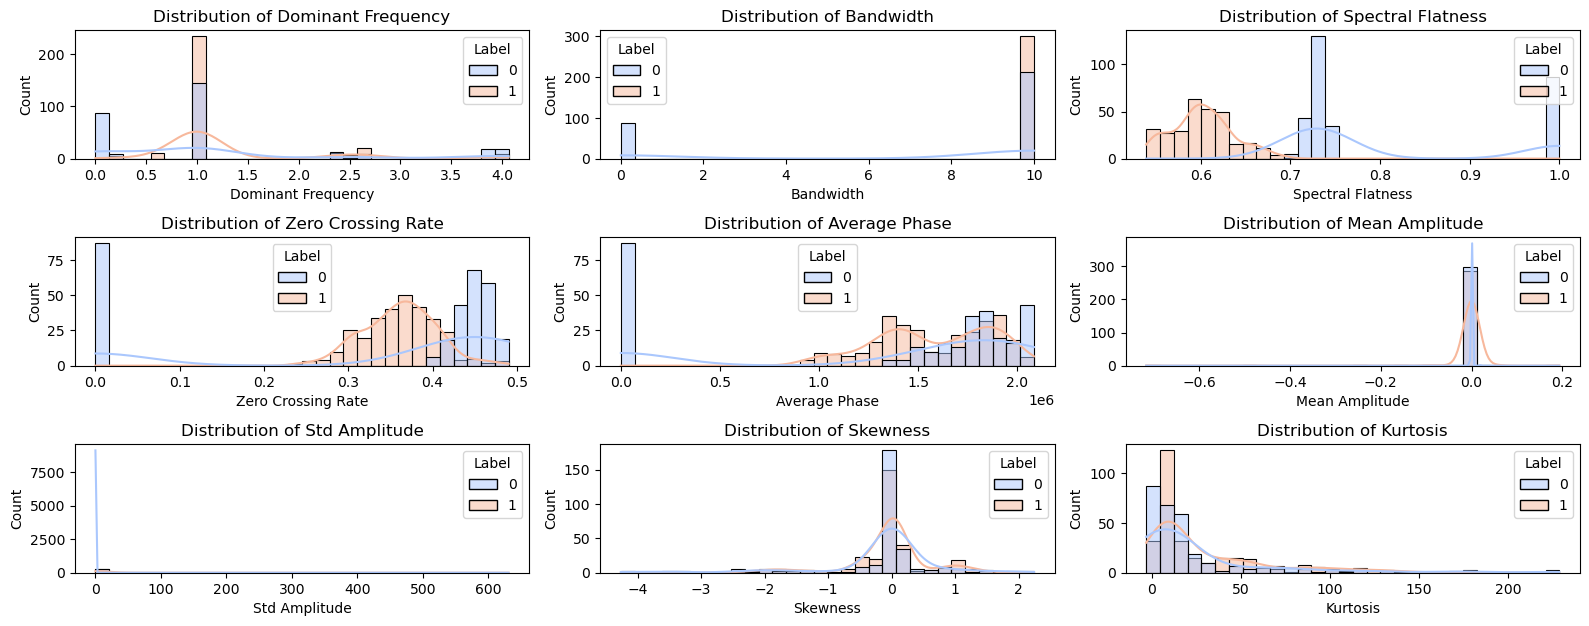

In [22]:
EPSILON = 1e-8  
warnings.filterwarnings("ignore", category=FutureWarning)

def extract_features(signals, sampling_rate=20):
    features = []
    for signal in signals:
        n = len(signal)
        # Frequency and Amplitude Features
        fft_values = fft(signal)
        amplitudes = np.abs(fft_values[:n // 2])
        frequencies = fftfreq(n, d=1 / sampling_rate)[:n // 2]
        dominant_frequency = frequencies[np.argmax(amplitudes)]
        
        # Frequency Bandwidth
        nonzero_indices = np.nonzero(amplitudes)[0]
        bandwidth = frequencies[nonzero_indices[-1]] - frequencies[nonzero_indices[0]] if len(nonzero_indices) > 0 else 0
        spectral_flatness = np.exp(np.mean(np.log(amplitudes + EPSILON))) / (np.mean(amplitudes) + EPSILON)
        zero_crossings = np.sum(np.diff(np.sign(signal)) != 0) / n
        
        phase = np.unwrap(np.angle(hilbert(signal)))
        avg_phase = np.mean(np.degrees(phase))
        mean_amplitude = np.mean(signal)
        std_amplitude = np.std(signal)
        skew_amplitude = np.mean(((signal - mean_amplitude) / (std_amplitude + EPSILON)) ** 3)
        kurt_amplitude = np.mean(((signal - mean_amplitude) / (std_amplitude + EPSILON)) ** 4) - 3
        
        # Combine all features
        features.append([
            dominant_frequency,
            bandwidth,
            spectral_flatness,
            zero_crossings,
            avg_phase,
            mean_amplitude,
            std_amplitude,
            skew_amplitude,
            kurt_amplitude
        ])
    return np.array(features)

synthetic_data = np.load(r'module_6_data/synthetic_data.npy')
labels = np.load(r'module_6_data/labels.npy')
features = extract_features(synthetic_data, sampling_rate=20)

feature_names = [
    "Dominant Frequency",
    "Bandwidth",
    "Spectral Flatness",
    "Zero Crossing Rate",
    "Average Phase",
    "Mean Amplitude",
    "Std Amplitude",
    "Skewness",
    "Kurtosis"
]

df = pd.DataFrame(features, columns=feature_names)
df['Label'] = labels
plt.figure(figsize=(16, 8))
for i, feature in enumerate(feature_names, 1):
    plt.subplot(4, 3, i)
    sns.histplot(data=df, x=feature, hue="Label", kde=True, palette="coolwarm", bins=30)
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Count")
plt.tight_layout()
plt.show()

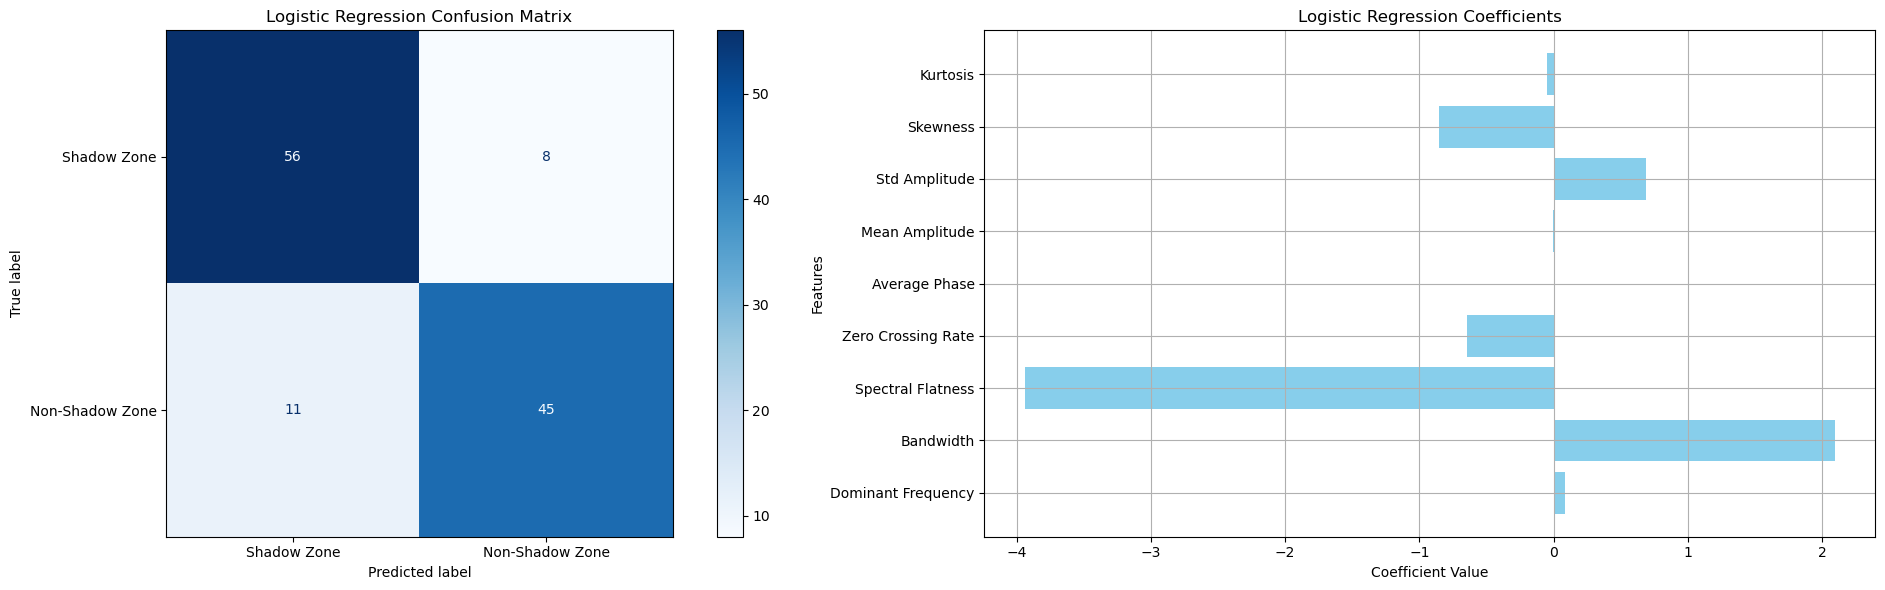


Logistic Regression Classification Report:
              precision  recall  f1-score  support
0                  0.84    0.88      0.85    64.00
1                  0.85    0.80      0.83    56.00
accuracy           0.84    0.84      0.84     0.84
macro avg          0.84    0.84      0.84   120.00
weighted avg       0.84    0.84      0.84   120.00

Logistic Regression Accuracy: 84.17%


In [23]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

log_reg_model = LogisticRegression(max_iter=1000, random_state=42)
log_reg_model.fit(X_train, y_train)
y_pred_log_reg = log_reg_model.predict(X_test)

fig, axes = plt.subplots(1, 2, figsize=(20, 6))

conf_matrix_log_reg = confusion_matrix(y_test, y_pred_log_reg)
disp_log_reg = ConfusionMatrixDisplay(conf_matrix_log_reg, display_labels=["Shadow Zone", "Non-Shadow Zone"])
disp_log_reg.plot(cmap="Blues", ax=axes[0])
axes[0].set_title("Logistic Regression Confusion Matrix")

log_reg_coefficients = log_reg_model.coef_[0]
axes[1].barh(feature_names, log_reg_coefficients, color='skyblue')
axes[1].set_title("Logistic Regression Coefficients")
axes[1].set_xlabel("Coefficient Value")
axes[1].set_ylabel("Features")
axes[1].grid()

plt.tight_layout()
plt.show()

def classification_report_to_df(y_true, y_pred):
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    df = pd.DataFrame(report_dict).transpose()
    df = df.round(2)
    return df

log_reg_report_df = classification_report_to_df(y_test, y_pred_log_reg)
print("\nLogistic Regression Classification Report:")
print(log_reg_report_df)
log_reg_accuracy = accuracy_score(y_test, y_pred_log_reg)
print(f"\nLogistic Regression Accuracy: {log_reg_accuracy * 100:.2f}%")


In [24]:
def bandpass_filter(data, sampling_rate, freqmin, freqmax):
    return bandpass(data, freqmin=freqmin, freqmax=freqmax, df=sampling_rate, corners=4, zerophase=True)

def process_mseed_files(directory_path):
    mseed_files = glob.glob(os.path.join(directory_path, "*.mseed"))
    mseed_files.sort()
    print(f"Found {len(mseed_files)} mseed files in {directory_path}")
    
    signals = []
    times = []
    sampling_rates = []
    for mseed_file in mseed_files:
        st = read(mseed_file)
        tr = st[0]
        sampling_rate = tr.stats.sampling_rate
        st.filter('bandpass', freqmin=0.1, freqmax=sampling_rate//2 -1)
        
        data = tr.data.astype(np.float32) / (100)
        filtered_data = bandpass_filter(data, sampling_rate, freqmin=0.1, freqmax=sampling_rate//2 -1)
        spike_removed_data = remove_spikes(filtered_data)
        wavelet_denoised_data = wavelet_denoise(spike_removed_data)
        denoised_data = remove_spikes(wavelet_denoised_data)
        signals.append(denoised_data)
        times.append(tr.times())
        sampling_rates.append(sampling_rate)
    return signals, times, sampling_rates

directory_path = r"module_6_data/data"  
signals, times, sampling_rates = process_mseed_files(directory_path)
features = extract_features(signals, sampling_rate=sampling_rates[0])  
predictions = log_reg_model.predict(features)

for i, (file, prediction) in enumerate(zip(mseed_files, predictions)):
    label = "Shadow Zone" if prediction == 0 else "Non-Shadow Zone"
    print(f"File: {os.path.basename(file)} -> Predicted Label: {label}")


Found 10 mseed files in module_6_data/data
File: XB.ELYSE.02.BHV.2019-05-23HR02_evid0041.mseed -> Predicted Label: Non-Shadow Zone
File: XB.ELYSE.02.BHV.2019-07-26HR12_evid0034.mseed -> Predicted Label: Non-Shadow Zone
File: XB.ELYSE.02.BHV.2019-09-21HR03_evid0032.mseed -> Predicted Label: Non-Shadow Zone
File: XB.ELYSE.02.BHV.2021-05-02HR01_evid0017.mseed -> Predicted Label: Non-Shadow Zone
File: XB.ELYSE.02.BHV.2021-10-11HR23_evid0011.mseed -> Predicted Label: Non-Shadow Zone
File: XB.ELYSE.02.BHV.2021-12-24HR22_evid0007.mseed -> Predicted Label: Non-Shadow Zone
File: XB.ELYSE.02.BHV.2022-01-02HR04_evid0006.mseed -> Predicted Label: Non-Shadow Zone
File: XB.ELYSE.02.BHV.2022-02-03HR08_evid0005.mseed -> Predicted Label: Non-Shadow Zone
File: XB.ELYSE.02.BHV.2022-04-09HR22_evid0002.mseed -> Predicted Label: Non-Shadow Zone
File: XB.ELYSE.02.BHV.2022-05-04HR23_evid0001.mseed -> Predicted Label: Non-Shadow Zone
